## Simulador de Recorridos ciclistas

### Importamos librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from keras.models import load_model
import pickle
import time

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn')

Using TensorFlow backend.


In [2]:
#Como tenemos procesado todo en el mismo fichero, lo cargamos

path = '../Entrenamientos/Procesado_Tramos.xlsx'
df = pd.read_excel(path)

### Filtramos datos

In [3]:
#Eliminar las filas que no tienen datos y seleccionamos la prueba que queremos simular
df = df[df["porc"]!=np.inf]
df = df[df["prueba"]=="20180429_LEMG_195_90_R_C.gpx"]

In [4]:
df.describe()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,60.500000,3496.016393,3547.770492,207.940679,94.262295,726.590164,35.150620,-1.333628,0.058167,49403.237132
std,35.362409,1946.877241,1937.072375,52.063138,172.804471,1130.014691,12.474903,13.483191,2.092644,27074.087892
min,0.000000,0.000000,16.000000,22.992004,1.000000,9.697469,12.922105,-14.992324,-6.597866,173.532309
25%,30.250000,2196.750000,2230.750000,180.272469,7.000000,61.750000,26.661969,-14.375875,-0.870941,30967.492612
50%,60.500000,3286.500000,3353.500000,223.516007,50.500000,466.777042,33.203336,-6.759451,0.003106,47158.500000
75%,90.750000,5248.500000,5283.500000,241.060519,92.750000,847.570583,41.207362,14.235446,0.859900,72401.000000
max,121.000000,6300.000000,6314.000000,299.800000,1158.000000,8788.000000,75.302316,14.918299,7.046886,88630.000000


In [5]:
#Se revisa que no existan datos anómalos
df.head()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum,prueba
0,0,0,16,196.808012,17,187.41664,39.688230,14.918299,-0.399565,173.532309,20180429_LEMG_195_90_R_C.gpx
1,1,16,75,230.996299,98,886.58336,32.568368,14.577416,0.523132,1055.000000,20180429_LEMG_195_90_R_C.gpx
2,2,75,122,194.043315,60,616.40000,36.984000,14.550887,-0.240187,1677.304307,20180429_LEMG_195_90_R_C.gpx
3,3,122,227,221.693546,193,1692.60000,31.571813,14.552940,0.895103,3364.000000,20180429_LEMG_195_90_R_C.gpx
4,4,227,273,169.324586,47,538.40000,41.239149,14.433466,-1.235191,3911.000000,20180429_LEMG_195_90_R_C.gpx


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   2.,
          0.,   0.,   1.,   1.,   0.,   3.,   0.,   0.,   1.,   0.,   2.,
          1.,   3.,   1.,   0.,   1.,   4.,   3.,   2.,   1.,   1.,   3.,
          1.,   3.,   3.,  11.,  18.,   8.,   1.,   3.,   3.,   3.,   4.,
          1.,   2.,   1.,   2.,   1.,   0.,   1.,   1.,   2.,   1.,   1.,
          1.,   1.,   1.,   2.,   3.,   2.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([-6.59786614, -6.46141862, -6.32497111, -6.18852359, -6.05207607,
        -5.91562855, -5.77918103, -5.64273351, -5.50628599, -5.36983847,
        -5.23339095, -5.09694343, -4.96049591, -4.82404839, -4.68760087,
        -4.55115335, -4.41470584, -4.27825832, -4.1418108 , -4.00536328,
        -3.86891576, -3.73

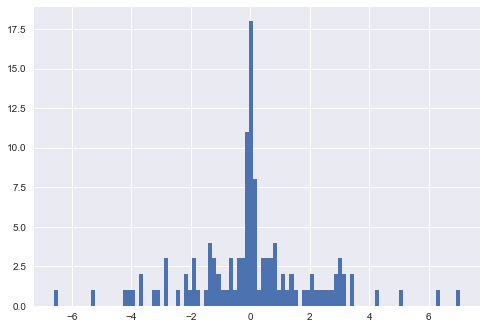

In [6]:
plt.hist(df['porc'],bins=100)

Vemos que la mayoría de tramos están centrados en porcentajes cercanos a 0, aunque también hay varios tramos de subidas y bajadas

In [13]:
#Prueba iterando en cada tramo con intervalos aleatorios con el modelo desarrollado CON TENSORFLOW (PRIMERA PASADA)

#Almacenamos la hora de inicio para evaluar el tiempo que tarda en ejecutar
start_time = time.time()

#Cargamos los dos modelos con los que vamos a trabajar
model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))

#Inicializamos las variables de control del flujo de ejecución
resultados = []

fail = 0 #Contador de simulaciones fallidas
exito = 0 #Contador de simulaciones correctas
num_pruebas = 5 #Número de éxitos para finalizar la simulación
fi = 0 #Variable para iterar

#Las siguientes variables se rellenan a criterio del entrenador o de quien use esta simulación
potencia_objetivo = 220
pot_min = 60
pot_max = 275
ff_1 = 0.4
ff_2 = 0.6

#Repetimos la simulación de pruebas hasta que tenemos un número de exitos concreto
while exito < num_pruebas:
    if (fi % 10) == 0:
        print('Empezamos la prueba %d' %fi)
        print("--- %s seconds ---" % (time.time() - start_time))
    
    #Reiniciamos la variables para acumular cada prueba
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    
    #Simulamos cada tramo de la prueba
    while i < len(df):
        
        #Recuperamos el porcentaje de la pendiente, el viento y la distancia
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
   
    
        #Asignamos la potencia inicial según la sigmoide que se puede consultar en ../Machine Learning/Warm-Start.ipynb
        #Adicionalmente introducimos un factor de variabilidad basado en el viento aparente (>0 si viento en contra y viceversa)           
        
        if viento<0:
            min_random = (viento/2)-1
            max_random = abs(viento**2)+1
        else:
            max_random = (viento/2)+1
            min_random = (-1*viento**2)-1
            
        potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))*(np.random.randint(min_random,max_random)+100)/100
        #potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))+np.random.randint(-100,100)
        potencia_min = pot_min+(pot_max-25-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))
        potencia_max = pot_min+25+(pot_max-pot_min-25)/(1+ff_1*np.e**(ff_2*porc*-1))
                                            
        if potencia_aux>potencia_max:
            potencia = potencia_max
        elif potencia_aux<potencia_min:
            potencia = potencia_min
        else:
            potencia = potencia_aux
        
        #Utilizamos el modelo de normalización entrenado para ajustar los datos de entrada
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        #Utilizamos el modelo de Tensor Flow para predecir la velocidad media de ese tramo
        velocidad = model_TF.predict(input_model)[0]
        
        #Con la velocidad del paso anterior y la distancia del tramo, calculamos el tiempo necesario para recorrerlo
        nuevo_tiempo = distancia/(velocidad/3.6)
        #Almacenamos la información del paso actual
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        #Acumulamos la potencia y el tiempo para evaluar el resultado final y determinar si es éxito o no, y con que tiempo total
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        i += 1
    
    potencia_media = potencia_acum/tiempo_acum
    print("Intento %d con potencia media %d" %(fi, potencia_media))
    
    #Si la potencia queda fuera de intervalos viables, no se considera como exito
    #Nos quedamos con +/-20w sobre la potencia objetivo para luego seleccionar las mejores distribuciones de potencia
    if (potencia_media > potencia_objetivo-5) and (potencia_media < potencia_objetivo+5):
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        #Contamos las simulaciones consideradas sin exito
        fail +=1
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos favorables: %d' %(len(resultados)))

C:\Users\David\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator RobustScaler from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Empezamos la prueba 0
--- 1.261425495147705 seconds ---
Intento 0 con potencia media 212
Intento 1 con potencia media 212
Intento 2 con potencia media 213
Intento 3 con potencia media 212
Intento 4 con potencia media 212
Intento 5 con potencia media 212
Intento 6 con potencia media 212
Intento 7 con potencia media 212
Intento 8 con potencia media 212
Intento 9 con potencia media 212
Empezamos la prueba 10
--- 3.041659355163574 seconds ---
Intento 10 con potencia media 212
Intento 11 con potencia media 212
Intento 12 con potencia media 213
Intento 13 con potencia media 212
Intento 14 con potencia media 212
Intento 15 con potencia media 211
Intento 16 con potencia media 212
Intento 17 con potencia media 212
Intento 18 con potencia media 215
Intento 19 con potencia media 211
Empezamos la prueba 20
--- 4.793320417404175 seconds ---
Intento 20 con potencia media 215
Intento 21 con potencia media 212
Intento 22 con potencia media 214
Intento 23 con potencia media 212
Intento 24 con potencia 

In [14]:
#Creamos DataFrame y renombramos las columnas
ds = pd.DataFrame(resultados)
ds.columns = ('intento','pwr','secs','list')
ds

,intento,pwr,secs,list
0,18,215.105652,11176.979492,"[[0, 185.964055394, 37.4165, 187.41664, 18.032..."
1,20,215.590851,11167.763672,"[[0, 185.964055394, 37.4165, 187.41664, 18.032..."
2,57,215.064850,11170.416992,"[[0, 208.239804137, 38.8238, 187.41664, 17.378..."
3,113,215.318848,11173.185547,"[[0, 185.964055394, 37.4165, 187.41664, 18.032..."
4,198,215.031860,11164.064453,"[[0, 185.964055394, 37.4165, 187.41664, 18.032..."


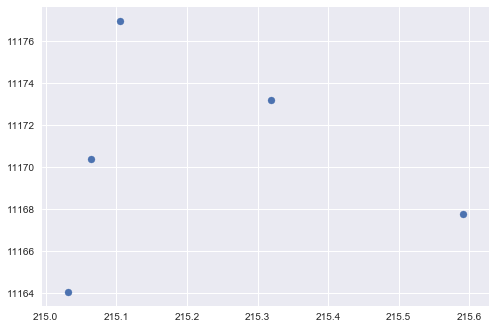

In [15]:
plt.scatter(ds['pwr'],ds['secs'])

En el scatter ya se ve con la misma potencia media tenemos distintos tiempos de finalización y viceversa

(array([ 1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 215.03186035,  215.04304016,  215.05421997,  215.06539978,
         215.07657959,  215.0877594 ,  215.09893921,  215.11011902,
         215.12129883,  215.13247864,  215.14365845,  215.15483826,
         215.16601807,  215.17719788,  215.18837769,  215.1995575 ,
         215.2107373 ,  215.22191711,  215.23309692,  215.24427673,
         215.25545654,  215.26663635,  215.27781616,  215.28899597,
         215.30017578,  215.31135559,  215.3225354 ,  215.33371521,
         215.34489502,  215.35607483,  215.36725464,  215.37843445,
         215.38961426,  215.40079407,  215.41197388,  215.42315369,
         215.4343335 ,  215.44551331,  215.45669312,  215.46787292,
         215.47905273,  215.49023254

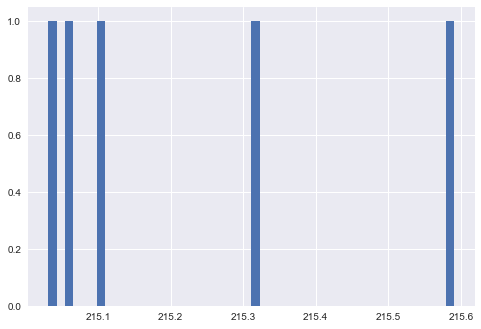

In [16]:
plt.hist(ds['pwr'],bins=50)

Histograma de potencias validas para la simulación

In [17]:
#Pintamos el mejor resultado
a = ds.groupby(['intento'])['secs'].agg('sum').sort_values(ascending=True)
a[:1].max()

11164.064453125

In [18]:
#Nos quedamos con los 50 mejores resultados para ser analizdos en Tableau
ganadores = pd.DataFrame(ds[ds['secs']<=a[:50].max()][['intento','list']])
ganadores

,intento,list
0,18,"[[0, 185.964055394, 37.4165, 187.41664, 18.032..."
1,20,"[[0, 185.964055394, 37.4165, 187.41664, 18.032..."
2,57,"[[0, 208.239804137, 38.8238, 187.41664, 17.378..."
3,113,"[[0, 185.964055394, 37.4165, 187.41664, 18.032..."
4,198,"[[0, 185.964055394, 37.4165, 187.41664, 18.032..."


In [19]:
#Agregamos las características de cada tramo al df de ganadores y sacamos el resultado a Excel
for i in range(len(ganadores)):
    if i == 0:
        df_ganador = pd.DataFrame(ganadores.values[i][1])
        df_ganador.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_ganador['Intento'] = ganadores.values[i][0]
    else:
        df_aux = pd.DataFrame(ganadores.values[i][1])
        df_aux.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_aux['Intento'] = ganadores.values[i][0]
        df_ganador = df_ganador.append([df_aux])
        del df_aux
df_ganador.to_excel('res_sim.xlsx')
df_ganador.head()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
0,0,185.964055,37.416451,187.41664,18.032173,-0.399565,14.918299,18
1,1,207.031177,34.099319,886.58336,93.600113,0.523132,14.577416,18
2,2,189.958469,36.806980,616.40000,60.288567,-0.240187,14.550887,18
3,3,213.997640,32.558739,1692.60000,187.149750,0.895103,14.552940,18
4,4,163.299662,39.647022,538.40000,48.887402,-1.235191,14.433466,18


In [36]:
df_ganador.describe()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
count,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000,610.000000
mean,60.500000,203.130052,32.942394,726.590164,91.561327,0.058167,-1.333628,81.200000
std,35.246085,42.878017,7.007433,1126.297528,161.461536,2.085760,13.438838,67.847671
min,0.000000,68.653638,14.088379,9.697469,0.961495,-6.597866,-14.992324,18.000000
25%,30.000000,187.419024,29.822900,61.000000,6.778424,-0.902205,-14.378223,20.000000
50%,60.500000,213.997640,32.513474,466.777042,51.643320,0.003106,-6.759451,57.000000
75%,91.000000,230.336300,36.842608,848.951282,93.234741,0.873832,14.238703,113.000000
max,121.000000,273.753424,53.248741,8788.000000,1149.423340,7.046886,14.918299,198.000000


(array([  10.,   15.,   30.,   16.,   55.,   50.,  121.,  178.,   74.,   61.]),
 array([  68.65363833,   89.16361686,  109.67359538,  130.18357391,
         150.69355243,  171.20353096,  191.71350949,  212.22348801,
         232.73346654,  253.24344506,  273.75342359]),
 <a list of 10 Patch objects>)

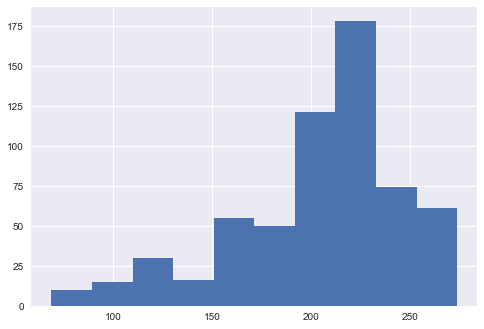

In [20]:
plt.hist(df_ganador['Potencia'])

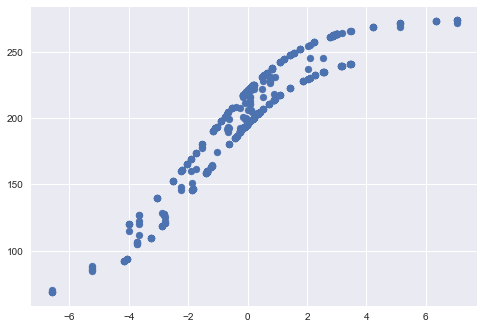

In [52]:
plt.scatter(df_ganador['Pendiente'],df_ganador['Potencia'])

La distribución de potencia es acorde a lo esperado

In [21]:
#Juntamos el resultado de la simulación con el recorrido original a efectos de comparativa posterior en Tableau
df_input = df[['tramo','pwr','spd','dist','time_seg','porc','viento_aparente']]
df_input.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
df_input['Intento'] = 'Original'
df_input.append([df_ganador]).to_excel('res_sim_ori.xlsx')
df_input.head()

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
0,0,196.808012,39.688230,187.41664,17,-0.399565,14.918299,Original
1,1,230.996299,32.568368,886.58336,98,0.523132,14.577416,Original
2,2,194.043315,36.984000,616.40000,60,-0.240187,14.550887,Original
3,3,221.693546,31.571813,1692.60000,193,0.895103,14.552940,Original
4,4,169.324586,41.239149,538.40000,47,-1.235191,14.433466,Original


In [56]:
potencias_medias = df_ganador.groupby(['Tramos'])['Potencia'].agg('median')

#### Posible mejora del modelo, inicializando la potencia de cada tramo con el mejor resultado de la primera simulación

In [58]:
#CON TENSORFLOW (SEGUNDA PASADA)
#Almacenamos la hora de inicio para evaluar el tiempo que tarda en ejecutar
start_time = time.time()

#Cargamos los dos modelos con los que vamos a trabajar
model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))

#Inicializamos las variables de control del flujo de ejecución
resultados = []

fail = 0 #Contador de simulaciones fallidas
exito = 0 #Contador de simulaciones correctas
num_pruebas = 50 #Número de éxitos para finalizar la simulación
fi = 0 #Variable para iterar

#Las siguientes variables se rellenan a criterio del entrenador o de quien use esta simulación
potencia_objetivo = 220
pot_min = 60
pot_max = 275
ff_1 = 0.3
ff_2 = 0.7

#Repetimos la simulación de pruebas hasta que tenemos un número de exitos concreto
while exito < num_pruebas:
    if (fi % 10) == 0:
        print('Empezamos la prueba %d' %fi)
        print("--- %s seconds ---" % (time.time() - start_time))
    
    #Reiniciamos la variables para acumular cada prueba
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    
    #Simulamos cada tramo de la prueba
    while i < len(df):
        
        #Recuperamos el porcentaje de la pendiente, el viento y la distancia
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
        
        #Asignamos la potencia inicial según la sigmoide que se puede consultar en ../Machine Learning/Warm-Start.ipynb
        #Adicionalmente introducimos un factor de variabilidad basado en el viento aparente (>0 si viento en contra y viceversa)           
        
        if viento<0:
            min_random = (viento/2)-1
            max_random = abs(viento*2)+1
        else:
            max_random = (viento/2)+1
            min_random = (-1*viento*2)-1
                
        potencia_aux = potencias_medias[i]*(np.random.randint(min_random,max_random)+100)/100
        potencia_min = pot_min+(pot_max-30-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))
        potencia_max = pot_min+30+(pot_max-pot_min-30)/(1+ff_1*np.e**(ff_2*porc*-1))
                                            
        if potencia_aux>potencia_max:
            potencia = potencia_max
        elif potencia_aux<potencia_min:
            potencia = potencia_min
        else:
            potencia = potencia_aux
        
        
        
        
        #Utilizamos el modelo de normalización entrenado para ajustar los datos de entrada
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        #Utilizamos el modelo de Tensor Flow para predecir la velocidad media de ese tramo
        velocidad = model_TF.predict(input_model)[0]
        
        #Con la velocidad del paso anterior y la distancia del tramo, calculamos el tiempo necesario para recorrerlo
        nuevo_tiempo = distancia/(velocidad/3.6)
        #Almacenamos la información del paso actual
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        #Acumulamos la potencia y el tiempo para evaluar el resultado final y determinar si es éxito o no, y con que tiempo total
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        i += 1
    
    potencia_media = potencia_acum/tiempo_acum
    print("Intento %d con potencia media %d" %(fi, potencia_media))
    
    #Si la potencia queda fuera de intervalos viables, no se considera como exito
    #Nos quedamos con +/-20w sobre la potencia objetivo para luego seleccionar las mejores distribuciones de potencia
    if (potencia_media > potencia_objetivo-5) and (potencia_media < potencia_objetivo+5):
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        #Contamos las simulaciones consideradas sin exito
        fail +=1
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos favorables: %d' %(len(resultados)))

C:\Users\David\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator RobustScaler from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Empezamos la prueba 0
--- 1.9838862419128418 seconds ---
Intento 0 con potencia media 214
Intento 1 con potencia media 215
Intento 2 con potencia media 216
Intento 3 con potencia media 217
Intento 4 con potencia media 213
Intento 5 con potencia media 212
Intento 6 con potencia media 212
Intento 7 con potencia media 215
Intento 8 con potencia media 216
Intento 9 con potencia media 213
Empezamos la prueba 10
--- 4.129041433334351 seconds ---
Intento 10 con potencia media 217
Intento 11 con potencia media 215
Intento 12 con potencia media 217
Intento 13 con potencia media 214
Intento 14 con potencia media 215
Intento 15 con potencia media 216
Intento 16 con potencia media 217
Intento 17 con potencia media 214
Intento 18 con potencia media 213
Intento 19 con potencia media 214
Empezamos la prueba 20
--- 6.141899824142456 seconds ---
Intento 20 con potencia media 214
Intento 21 con potencia media 216
Intento 22 con potencia media 216
Intento 23 con potencia media 213
Intento 24 con potencia

In [62]:
#Creamos DataFrame y renombramos las columnas
ds = pd.DataFrame(resultados)
ds.columns = ('intento','pwr','secs','list')
ds

,intento,pwr,secs,list
0,1,215.767944,11175.659180,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
1,2,216.875412,11136.723633,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
2,3,217.516144,11110.160156,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
3,7,215.183304,11209.072266,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
4,8,216.480606,11157.498047,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
5,10,217.139618,11121.830078,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
6,11,215.925354,11188.201172,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
7,12,217.207291,11103.386719,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
8,14,215.514542,11183.420898,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
9,15,216.480164,11156.585938,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."


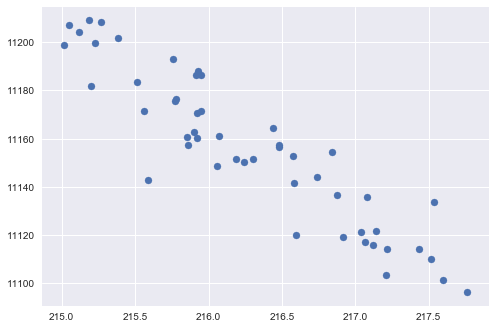

In [63]:
plt.scatter(ds['pwr'],ds['secs'])

En el scatter ya se ve con la misma potencia media tenemos distintos tiempos de finalización y viceversa

(array([ 2.,  1.,  0.,  3.,  1.,  0.,  1.,  0.,  0.,  1.,  2.,  0.,  0.,
         3.,  0.,  2.,  7.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,
         2.,  0.,  3.,  0.,  0.,  1.,  0.,  2.,  1.,  0.,  1.,  2.,  2.,
         1.,  1.,  0.,  0.,  0.,  1.,  2.,  0.,  1.,  0.,  1.]),
 array([ 215.01348877,  215.06846985,  215.12345093,  215.17843201,
         215.23341309,  215.28839417,  215.34337524,  215.39835632,
         215.4533374 ,  215.50831848,  215.56329956,  215.61828064,
         215.67326172,  215.7282428 ,  215.78322388,  215.83820496,
         215.89318604,  215.94816711,  216.00314819,  216.05812927,
         216.11311035,  216.16809143,  216.22307251,  216.27805359,
         216.33303467,  216.38801575,  216.44299683,  216.49797791,
         216.55295898,  216.60794006,  216.66292114,  216.71790222,
         216.7728833 ,  216.82786438,  216.88284546,  216.93782654,
         216.99280762,  217.0477887 ,  217.10276978,  217.15775085,
         217.21273193,  217.26771301

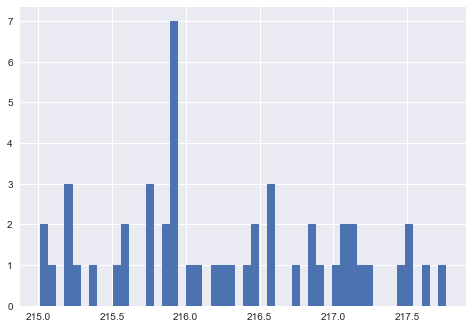

In [64]:
plt.hist(ds['pwr'],bins=50)

Histograma de potencias validas para la simulación

In [65]:
#Pintamos el mejor resultado
a = ds.groupby(['intento'])['secs'].agg('sum').sort_values(ascending=True)
a[:1].max()

11096.2900390625

In [66]:
#Nos quedamos con los 50 mejores resultados para ser analizdos en Tableau
ganadores = pd.DataFrame(ds[ds['secs']<=a[:50].max()][['intento','list']])
ganadores

,intento,list
0,1,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
1,2,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
2,3,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
3,7,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
4,8,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
5,10,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
6,11,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
7,12,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
8,14,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."
9,15,"[[0, 192.443887387, 37.9519, 187.41664, 17.777..."


In [67]:
#Agregamos las características de cada tramo al df de ganadores y sacamos el resultado a Excel
for i in range(len(ganadores)):
    if i == 0:
        df_ganador = pd.DataFrame(ganadores.values[i][1])
        df_ganador.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_ganador['Intento'] = ganadores.values[i][0]
    else:
        df_aux = pd.DataFrame(ganadores.values[i][1])
        df_aux.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_aux['Intento'] = ganadores.values[i][0]
        df_ganador = df_ganador.append([df_aux])
        del df_aux
df_ganador.to_excel('res_sim.xlsx')
df_ganador.head()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
0,0,192.443887,37.951916,187.41664,17.777756,-0.399565,14.918299,1
1,1,213.144321,34.492664,886.58336,92.532722,0.523132,14.577416,1
2,2,196.538673,37.350746,616.40000,59.410858,-0.240187,14.550887,1
3,3,219.437933,32.908787,1692.60000,185.159058,0.895103,14.552940,1
4,4,168.045555,40.039204,538.40000,48.408554,-1.235191,14.433466,1


In [68]:
df_ganador.describe()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
count,6100.00000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.000000,6100.00000
mean,60.50000,207.241201,33.214012,726.590164,91.441791,0.058167,-1.333628,60.64000
std,35.22007,43.513058,7.040832,1125.466210,162.197537,2.084220,13.428919,41.17898
min,0.00000,65.891201,14.051772,9.697469,0.941542,-6.597866,-14.992324,1.00000
25%,30.00000,192.443887,30.121281,61.000000,6.699200,-0.902205,-14.378223,22.00000
50%,60.50000,215.449948,32.793774,466.777042,51.415636,0.003106,-6.759451,57.50000
75%,91.00000,234.740696,37.350746,848.951282,92.494492,0.873832,14.238703,91.00000
max,121.00000,274.600921,53.386795,8788.000000,1233.999268,7.046886,14.918299,133.00000


(array([   68.,   189.,   294.,   150.,   486.,   260.,  1429.,  1468.,
         1098.,   658.]),
 array([  65.89120134,   86.76217333,  107.63314532,  128.50411731,
         149.37508931,  170.2460613 ,  191.11703329,  211.98800528,
         232.85897728,  253.72994927,  274.60092126]),
 <a list of 10 Patch objects>)

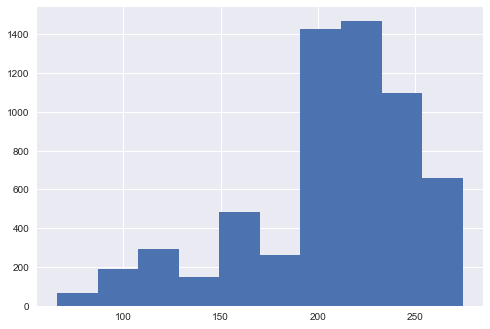

In [69]:
plt.hist(df_ganador['Potencia'])

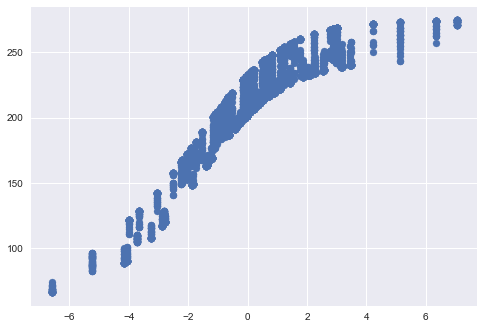

In [70]:
plt.scatter(df_ganador['Pendiente'],df_ganador['Potencia'])